# OptiMask: Efficient Python Package for NaN Data Removal

OptiMask is a Python package designed for efficiently handling NaN values in matrices, specifically focusing on computing **the largest non-contiguous submatrix without NaN**. In contrast to optimal but computationally expensive linear programming approaches, OptiMask employs a heuristic method, relying solely on Numpy for speed and efficiency. In machine learning applications, OptiMask surpasses traditional methods like Pandas `dropna` by maximizing the amount of valid data available for model fitting. It strategically identifies the optimal set of columns and rows to retain or remove, ensuring that the largest non-contiguous submatrix without NaN is utilized for training models.

Cyril Joly

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from optimask import OptiMask

In [2]:
def plot(data, rows_to_keep=None, cols_to_keep=None, rows_to_remove=None, cols_to_remove=None, figsize=None, title=None, xticks=None, yticks=None, show=True):
    cmap = plt.get_cmap("coolwarm")
    cmap.set_bad('grey')
    x = data.copy()
    m, n = data.shape

    if rows_to_keep is not None:
        x[[i for i in range(m) if i not in rows_to_keep]] += 1
    if cols_to_keep is not None:
        x[:, [j for j in range(n) if j not in cols_to_keep]] += 1
    if rows_to_remove is not None:
        x[rows_to_remove] += 1
    if cols_to_remove is not None:
        x[:, cols_to_remove] += 1

    if figsize:
        plt.figure(figsize=figsize)

    plt.pcolormesh(np.clip(x, 0, 1), cmap=cmap)
    plt.gca().set_aspect('equal')
    plt.title(title)

    if xticks is not None:
        plt.xticks(np.arange(n)+0.5, xticks, rotation=90, size='x-small')
    if yticks is not None:
        plt.yticks(np.arange(m)+0.5, yticks, size='x-small')
    if (xticks is None) and (xticks is None):
        plt.gca().axis('off')

    if show:
        plt.show()


def generate_random(m, n, ratio):
    """Missing at random arrays"""
    arr = np.zeros((m, n))
    nan_count = int(ratio * m * n)
    indices = np.random.choice(m * n, nan_count, replace=False)
    arr.flat[indices] = np.nan
    return arr

## 1. OptiMask API

OptiMask is easy to use. It can be applied to NumPy arrays or pandas DataFrames, returning a subarray or subframe without NaN or the retained rows/columns. Since multiple optimizations are carried out starting from random states, a `random_state` parameter is provided for reproducibility.

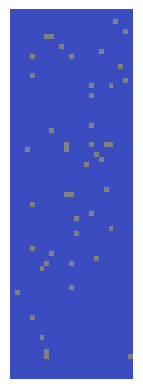

In [3]:
x = generate_random(m=75, n=25, ratio=0.025)
plot(x)

In [4]:
%time rows, cols = OptiMask(random_state=0).solve(x)
len(rows), len(cols), np.any(np.isnan(x[rows][:, cols]))

CPU times: total: 0 ns
Wall time: 2.51 ms


(50, 21, False)

In red the removed rows and columns, in blue the remaining submatrix without NaN:

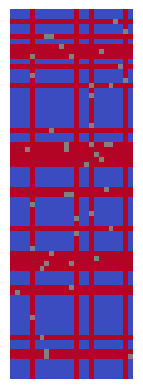

In [5]:
plot(x, rows_to_keep=rows, cols_to_keep=cols)

OptiMask can directly return the submatrix:

In [6]:
xt = OptiMask(random_state=0).solve(x, return_data=True)
xt.shape, np.any(np.isnan(xt))

((50, 21), False)

OptiMask offers a verbose mode to inspect the results of the intermediate optimizations:

In [7]:
xt = OptiMask(random_state=0, verbose=True).solve(x, return_data=True)
xt.shape, np.any(np.isnan(xt))

36 rows and 20 columns contain NaNs.
	Trial 1 : submatrix of size 45x23 (1035 elements) found.
	Trial 2 : submatrix of size 53x19 (1007 elements) found.
	Trial 3 : submatrix of size 46x22 (1012 elements) found.
	Trial 4 : submatrix of size 50x21 (1050 elements) found.
	Trial 5 : submatrix of size 49x21 (1029 elements) found.
	Trial 6 : submatrix of size 50x20 (1000 elements) found.
	Trial 7 : submatrix of size 41x24 (984 elements) found.
	Trial 8 : submatrix of size 44x23 (1012 elements) found.
	Trial 9 : submatrix of size 45x22 (990 elements) found.
	Trial 10 : submatrix of size 52x20 (1040 elements) found.
Result: the largest submatrix found is of size 50x21 (1050 elements) found.


((50, 21), False)

OptiMask provides a n_tries parameter, which enhances the probability of finding a better solution:

In [8]:
%time xt = OptiMask(n_tries=35, random_state=0, verbose=True).solve(x, return_data=True)
xt.shape, np.any(np.isnan(xt))

36 rows and 20 columns contain NaNs.
	Trial 1 : submatrix of size 45x23 (1035 elements) found.
	Trial 2 : submatrix of size 53x19 (1007 elements) found.
	Trial 3 : submatrix of size 46x22 (1012 elements) found.
	Trial 4 : submatrix of size 50x21 (1050 elements) found.
	Trial 5 : submatrix of size 49x21 (1029 elements) found.
	Trial 6 : submatrix of size 50x20 (1000 elements) found.
	Trial 7 : submatrix of size 41x24 (984 elements) found.
	Trial 8 : submatrix of size 44x23 (1012 elements) found.
	Trial 9 : submatrix of size 45x22 (990 elements) found.
	Trial 10 : submatrix of size 52x20 (1040 elements) found.
	Trial 11 : submatrix of size 42x24 (1008 elements) found.
	Trial 12 : submatrix of size 43x23 (989 elements) found.
	Trial 13 : submatrix of size 39x25 (975 elements) found.
	Trial 14 : submatrix of size 39x25 (975 elements) found.
	Trial 15 : submatrix of size 45x23 (1035 elements) found.
	Trial 16 : submatrix of size 44x23 (1012 elements) found.
	Trial 17 : submatrix of size 48x

((48, 22), False)

OptiMask can also handle pandas DataFrames:

In [9]:
df = pd.DataFrame(x, columns=[f'feature {k}' for k in range(x.shape[1])])
df.sample(3)

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 15,feature 16,feature 17,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature 0   75 non-null     float64
 1   feature 1   74 non-null     float64
 2   feature 2   75 non-null     float64
 3   feature 3   74 non-null     float64
 4   feature 4   70 non-null     float64
 5   feature 5   75 non-null     float64
 6   feature 6   73 non-null     float64
 7   feature 7   71 non-null     float64
 8   feature 8   72 non-null     float64
 9   feature 9   75 non-null     float64
 10  feature 10  74 non-null     float64
 11  feature 11  72 non-null     float64
 12  feature 12  71 non-null     float64
 13  feature 13  73 non-null     float64
 14  feature 14  75 non-null     float64
 15  feature 15  74 non-null     float64
 16  feature 16  70 non-null     float64
 17  feature 17  73 non-null     float64
 18  feature 18  73 non-null     float64
 19  feature 19  73 non-null     flo

In [11]:
dft = OptiMask(n_tries=35).solve(df, return_data=True)
dft.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 0 to 74
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature 0   48 non-null     float64
 1   feature 1   48 non-null     float64
 2   feature 2   48 non-null     float64
 3   feature 3   48 non-null     float64
 4   feature 5   48 non-null     float64
 5   feature 6   48 non-null     float64
 6   feature 7   48 non-null     float64
 7   feature 8   48 non-null     float64
 8   feature 9   48 non-null     float64
 9   feature 10  48 non-null     float64
 10  feature 11  48 non-null     float64
 11  feature 12  48 non-null     float64
 12  feature 13  48 non-null     float64
 13  feature 14  48 non-null     float64
 14  feature 15  48 non-null     float64
 15  feature 17  48 non-null     float64
 16  feature 18  48 non-null     float64
 17  feature 19  48 non-null     float64
 18  feature 21  48 non-null     float64
 19  feature 22  48 non-null     float64


In [12]:
index, columns = OptiMask(n_tries=35).solve(df)
index, columns

(Index([ 0,  1,  2,  3,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 26,
        27, 28, 31, 33, 34, 35, 36, 39, 40, 41, 42, 48, 49, 51, 52, 53, 54, 55,
        56, 57, 58, 61, 62, 64, 68, 71, 73, 74],
       dtype='int64'),
 Index(['feature 0', 'feature 1', 'feature 2', 'feature 3', 'feature 5',
        'feature 6', 'feature 7', 'feature 8', 'feature 9', 'feature 10',
        'feature 11', 'feature 12', 'feature 13', 'feature 14', 'feature 15',
        'feature 17', 'feature 18', 'feature 19', 'feature 20', 'feature 21',
        'feature 22', 'feature 23', 'feature 24'],
       dtype='object'))

## 2. Understanding the problem at hand

In the context of a matrix containing a lone NaN cell, the central challenge emerges: determining whether to eliminate the corresponding row or column. This decision is readily resolved by examining the matrix's shape. Specifically, if the matrix has a greater number of rows than columns, the optimal approach involves removing the associated row. Conversely, when the matrix has more columns than rows, the most effective course of action is to eliminate the corresponding column:

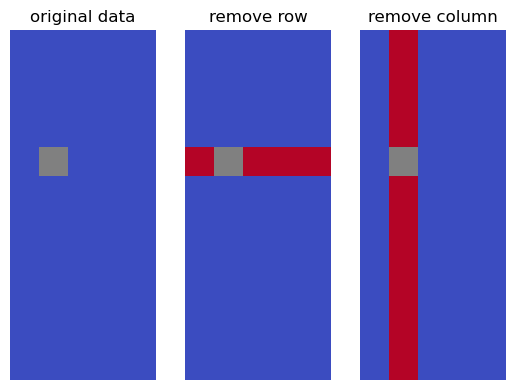

In [13]:
x = np.zeros((12, 5))
x[7, 1] = np.nan

plt.figure()
plt.subplot(1, 3, 1)
plot(x, show=False, title='original data')
plt.subplot(1, 3, 2)
plot(x, rows_to_remove=[7], show=False, title='remove row')
plt.subplot(1, 3, 3)
plot(x, cols_to_remove=[1], show=False, title='remove column')
plt.show()

Eliminating the highlighted row yields the most extensive submatrix devoid of NaN. This solution remains optimal even when additional NaN values are present within the same row:

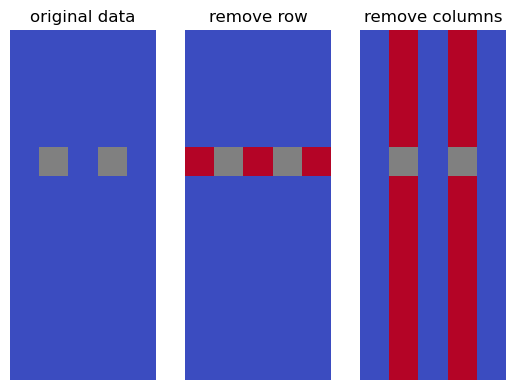

In [14]:
x = np.zeros((12, 5))
x[7, [1, 3]] = np.nan

plt.figure()
plt.subplot(1, 3, 1)
plot(x, show=False, title='original data')
plt.subplot(1, 3, 2)
plot(x, rows_to_remove=[7], show=False, title='remove row')
plt.subplot(1, 3, 3)
plot(x, cols_to_remove=[1, 3], show=False, title='remove columns')
plt.show()

But what about more complex cases ? 

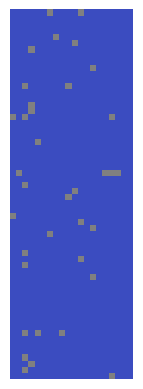

In [15]:
m, n = 60, 20
ratio = 0.03
x = generate_random(m, n, ratio)

plot(x)

## 3. The Problem from an Optimization Perspective

This problem can be formalized as a binary optimization problem in two ways.

### 3.1. Linear programming

Source : [this mathematica.stackexchange answer](https://mathematica.stackexchange.com/a/108513/92680), posted by [unlikely](https://mathematica.stackexchange.com/users/16267/unlikely).

Given:

- Matrix $A$ of shape $m \times n$ and elements $a_{i,j}$
- The goal is to determine the values of variables $(i \in [1~..~m]$, $j \in [1~..~n])$:
  - $e_{i,j} \in \{0,1\}$ (1 if element $(i,j)$ should be removed, 0 otherwise)
  - $r_i \in \{0,1\}$ (1 if row $i$ should be removed, 0 otherwise)
  - $c_j \in \{0,1\}$ (1 if column $j$ should be removed, 0 otherwise)



Subject to:


- $e_{i,j} = 1$ for every $(i,j)$ such that $a_{i,j}$ is a NaN
- $r_i + c_j \geq e_{i,j}$, meaning if $e_{i,j} = 1$ then either $r_i = 1$ or $c_j = 1$, or both
- $e_{i,j} \geq r_i$, indicating if $r_i = 1$ then $e_{i,j}$ must be 1
- $e_{i,j} \geq c_j$, indicating if $c_j = 1$ then $e_{i,j}$ must be 1

The objective is to minimize the total number of deleted cells:

$$\sum_{i=1}^{m} \sum_{j=1}^{n} e_{i,j}$$

The optimal values of $r_i$ and $c_j$ provide us with the specific rows and columns to remove, ensuring that the remaining matrix is efficiently processed and devoid of NaN values. This problem can be solved in Python using the usual tools of linear programming, such as combining Pyomo with GLPK. Its disadvantage is being relatively expensive, as for an $m \times n$ matrix, more than $m \times n$ (binary) variables are used.

CPU times: total: 156 ms
Wall time: 527 ms


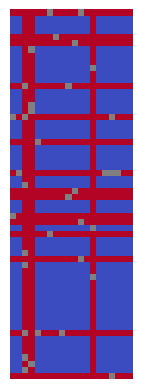

The largest submatrix without NaN is of size 45x17 (765 elements among 1056)


In [16]:
from pyomo.environ import Binary, ConcreteModel, ConstraintList, Objective, SolverFactory, Var, minimize


def linear_programming(matrix):
    m, n = matrix.shape
    model = ConcreteModel()

    # Variables
    model.e = Var(range(1, m + 1), range(1, n + 1), within=Binary)
    model.r = Var(range(1, m + 1), within=Binary)
    model.c = Var(range(1, n + 1), within=Binary)

    # Objective
    model.obj = Objective(expr=sum(model.e[i, j] for i in range(1, m + 1) for j in range(1, n + 1)), sense=minimize)

    # Constraints
    positions = [(i, j) for i in range(1, m + 1) for j in range(1, n + 1)]
    nan_positions = [(i, j) for (i, j) in positions if np.isnan(matrix[i - 1, j - 1])]

    model.nan_constraints = ConstraintList()
    for i, j in nan_positions:
        model.nan_constraints.add(model.e[i, j] == 1)

    model.other_constraints = ConstraintList()
    for i, j in positions:
        model.other_constraints.add(model.r[i] + model.c[j] >= model.e[i, j])
        model.other_constraints.add(model.e[i, j] >= model.r[i])
        model.other_constraints.add(model.e[i, j] >= model.c[j])

    # Solve the model
    solver = SolverFactory('glpk')
    solver.solve(model)

    # Extract the results
    rows_to_keep = [i-1 for i in range(1, m + 1) if model.r[i].value == 0]
    cols_to_keep = [j-1 for j in range(1, n + 1) if model.c[j].value == 0]

    return rows_to_keep, cols_to_keep


%time rows, cols = linear_programming(x)

plot(x, rows_to_keep=rows, cols_to_keep=cols)
print(f"The largest submatrix without NaN is of size {len(rows)}x{len(cols)} ({len(rows)*len(cols)} elements among {xt.size})")

Although producing the optimal solution, this approach becomes intractable for large-sized matrices.

### 3.2. Quadratic Programming

By employing the variables mentioned earlier, an alternate perspective of the problem involves maximizing $$(m-\sum_{i=1}^m r_i) \times (n-\sum_{i=1}^n c_j)$$
while considering:
- $r_i + c_j \ge 1$ for each $(i,j)$ where $a_{i,j}$ is a NaN.

Although the number of variables is reduced, the optimization problem becomes more challenging.

## 4. OptiMask
### 4.1. The algorithm

OptiMask's algorithm aims to identify the optimal set of rows and columns for removal, maximizing the size of the submatrix without NaN values. Notably, a formal proof of convergence for this algorithm is currently *unavailable*.

The algorithm iteratively computes permutations of rows and columns until a specific convergence criterion is met. This criterion relies on detecting a contiguous and well-ordered NaN frontier, similar to a **Pareto efficiency frontier**. Once identified, the problem simplifies to finding the largest contiguous rectangle, a computationally straightforward task. The stored permutations help pinpoint the rows and columns to be removed.

OptiMask's algorithm is heuristic, introducing uncertainty compared to a linear programming approach. To increase the likelihood of an optimal solution, the algorithm undergoes multiple optimizations through repeated restarts with random permutations. The `n_tries` parameter controls the number of restarts, while the random_state parameter ensures reproducibility.

Let `x` represent the array with missing values to be processed:

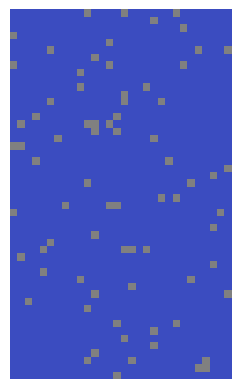

In [17]:
x = generate_random(m=50, n=30, ratio=0.05)
plot(x)

The first step is to isolate the rows and columns with at least one NaN value. We know that the rows or columns with zero NaN values will necessarily be part of the sought submatrix. Now we work with a boolean matrix, which is set to True at the NaN cells of the original data. We introduce `hx` and `hy`, representing the indices of the highest True in each column and the indices of the rightmost True in each row, respectively.

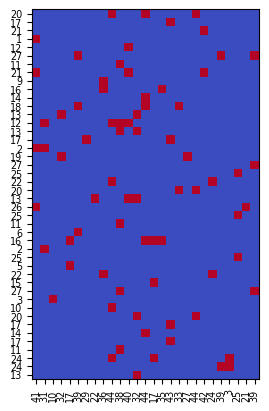

In [18]:
nan_rows, nan_cols = np.isnan(x).nonzero()
nan_rows, nan_cols = np.unique(nan_rows), np.unique(nan_cols)
xp = np.isnan(x[nan_rows][:, nan_cols])
hx, hy = OptiMask._heights(xp, axis=0), OptiMask._heights(xp, axis=1)
plot(xp, xticks=hx, yticks=hy)

The algorithm's core involves computing a series of permutations with the objective of ordering `hx` and `hy` to establish a Pareto frontier of NaN. This implies that both `hx` and `hy` should exhibit a decreasing trend. Importantly, at each step, the algorithm performs a permutation to order `hx`, followed by a permutation to order `hy`, and then alternates back and forth between `hx` and `hy` until both sequences exhibit a decreasing order.

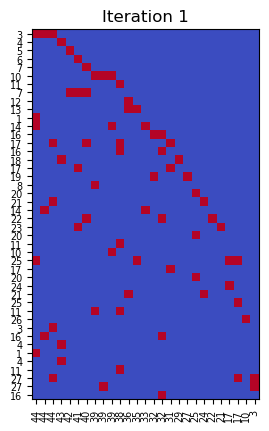

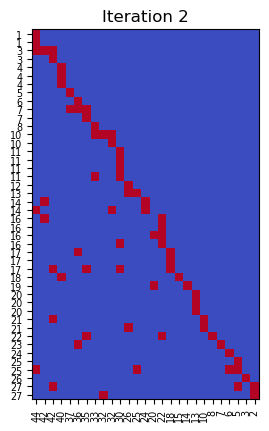

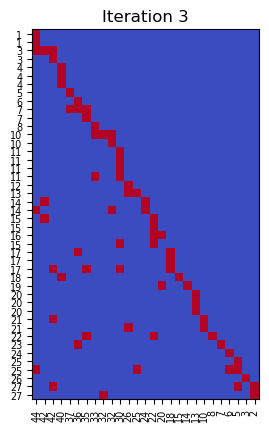

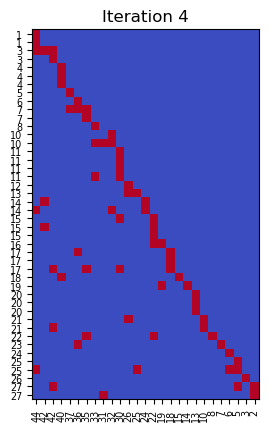

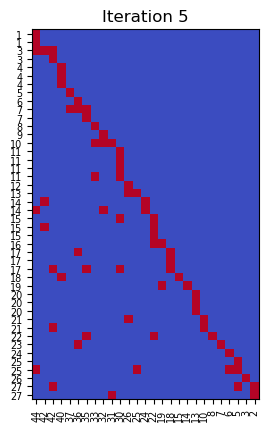

In [19]:
hx, hy = OptiMask._heights(xp, axis=0), OptiMask._heights(xp, axis=1)
k = 0
while not OptiMask._is_pareto_ordered(hx, hy):
    axis = (k % 2)
    p_step = np.argsort(-OptiMask._heights(xp, axis=axis))
    if axis == 0:
        xp = xp[:, p_step]
    if axis == 1:
        xp = xp[p_step]
    hx, hy = OptiMask._heights(xp, axis=0), OptiMask._heights(xp, axis=1)
    plot(xp, xticks=hx, yticks=hy, title=f'Iteration {k+1}')
    k += 1

Then, we can now seek the largest **contiguous rectangle** starting from the **upper right** of the matrix (without forgetting the rows and columns without NaN, not displayed here). Since we have kept track of the successive permutations, both over rows and columns, the algorithm can return the rows and columns to remove (or keep).

This computation is performed `n_tries` times over a copy of the matrix to process, where its rows and columns are each time randomly permuted. Each iteration results in a different NaN frontier and a different set of rows and columns to remove. After the `n_tries` computations, the set that leads to the largest submatrix without NaN is retained. Therefore, increasing n_tries leads to better results, and it may even reach the optimal one.

### 4.2. `n_tries` influence on the quality of the solution

Given an `m`x`n` matrix with missing values occurring at a random frequency of `ratio`, how does increasing `n_tries` influence the size of the computed submatrix?

In [20]:
def convergence_plot(m, n, ratio, n_tries, n_permutations=1000):
    def cummax(arr): return np.maximum.accumulate(arr)

    x = generate_random(m, n, ratio)
    opt_rows, opt_cols = linear_programming(x)
    opt_size = len(opt_rows) * len(opt_cols)

    optimask = OptiMask(n_tries=1)

    ret = np.zeros(n_tries)
    for k in range(n_tries):
        rows, cols = optimask.solve(x)
        ret[k] = len(rows) * len(cols)

    ret_mean = np.zeros_like(ret, dtype=float)

    plt.figure(figsize=(8, 3))
    for _ in range(n_permutations):
        ret_iter = cummax(ret[np.random.permutation(len(ret))])
        plt.plot(ret_iter, c='grey', lw=0.05)
        ret_mean += ret_iter / n_permutations
    plt.plot(ret_mean, c='k', lw=2)
    plt.axhline(y=opt_size, c='r', linestyle='dashed')
    plt.xlabel('number of random restarts')
    plt.ylabel('size of the solution')
    plt.title("Effect of Randomized Restarts on Heuristic Solution Quality")
    plt.xlim(0, n_tries)
    plt.text(x=1.025*n_tries, y=opt_size, s='size of the optimal solution', c='r')
    plt.show()

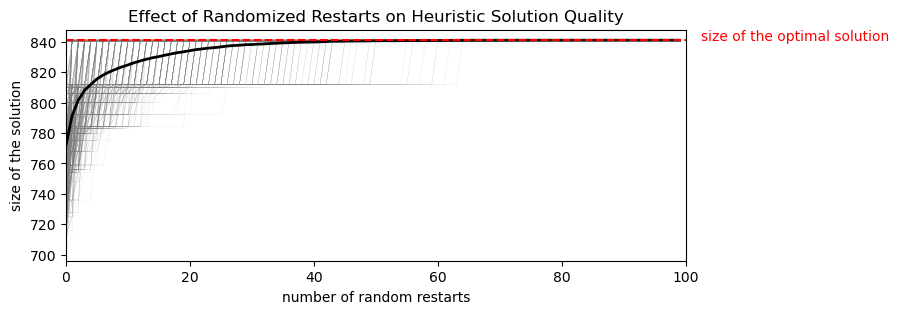

In [21]:
convergence_plot(m=40, n=40, ratio=0.025, n_tries=100)

### 4.3. What about structured NaN patterns ?

OptiMask is also efficient on structured NaN patterns (the largest submatrix found is in blue, the removed cells are in red):

In [22]:
def solve_and_plot(x):
    rows, cols = OptiMask().solve(x)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plot(x, show=False)
    plt.subplot(1, 2, 2)
    plot(x, rows_to_keep=rows, cols_to_keep=cols)
    plt.show()

In [23]:
n = 31

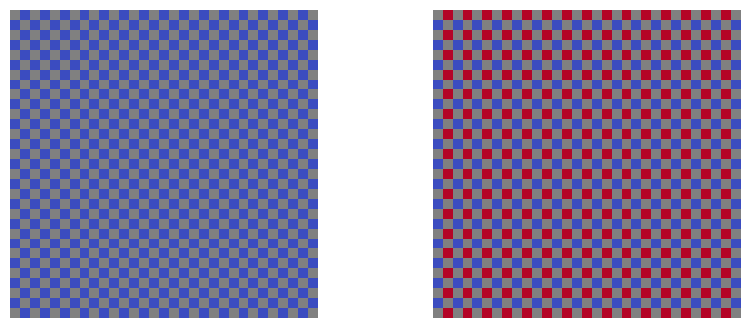

In [24]:
x = np.zeros((n, n))
iy, ix = np.indices(x.shape)
x[np.mod(iy+ix, 2) == 0] = np.nan
solve_and_plot(x)

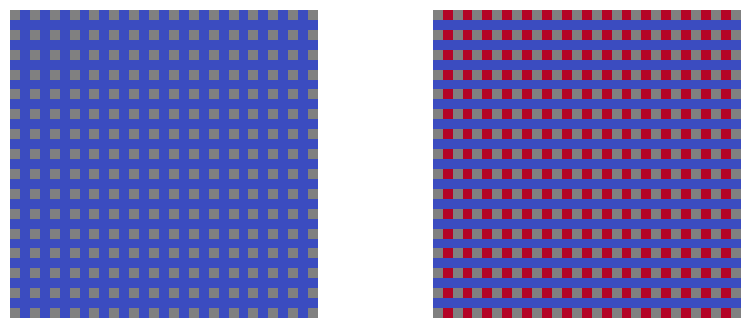

In [25]:
x = np.zeros((n, n))
iy, ix = np.indices(x.shape)
x[(np.mod(ix, 2) == 0) & (np.mod(iy, 2) == 0)] = np.nan
solve_and_plot(x)

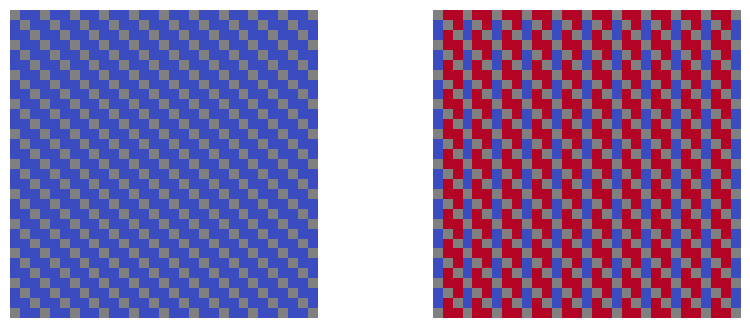

In [26]:
x = np.zeros((n, n))
iy, ix = np.indices(x.shape)
x[np.mod(iy+ix, 3) == 0] = np.nan
solve_and_plot(x)

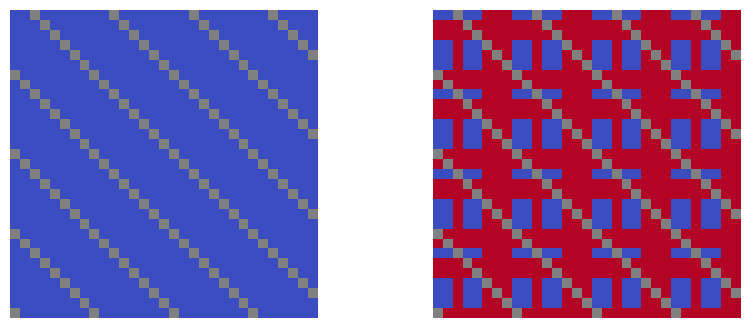

In [27]:
x = np.zeros((n, n))
iy, ix = np.indices(x.shape)
x[np.mod(iy+ix, 8) == 0] = np.nan
solve_and_plot(x)

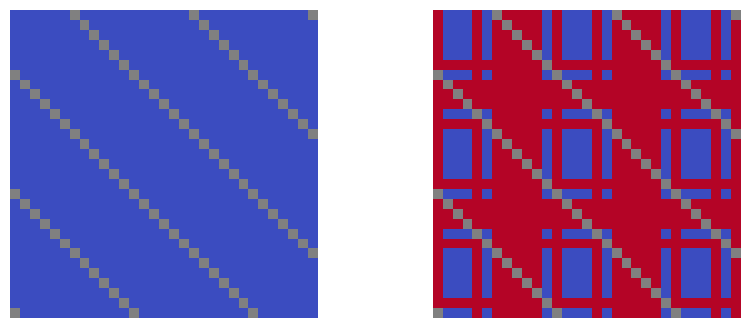

In [28]:
x = np.zeros((n, n))
iy, ix = np.indices(x.shape)
x[np.mod(iy+ix, 12) == 0] = np.nan
solve_and_plot(x)